# Law Chatbot Using Retrieval Augmented Generation (RAG)

This project aims to develop a Large Language Model (LLM) with Retrieval Augmented Generation (RAG) support.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

RAG stands for Retrieval Augmented Generation.

It was introduced in the paper [*Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*](https://arxiv.org/abs/2005.11401).

Each step can be roughly broken down to:

* **Retrieval** - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
* **Augmented** - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
* **Generation** - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.

## Why RAG?

The primary goal of Retrieval-Augmented Generation (RAG) is to enhance the output quality of large language models (LLMs).

Two primary improvements can be seen as:
1. **Preventing hallucinations** - LLMs are powerful but can sometimes generate plausible yet incorrect information. RAG pipelines mitigate this by providing factual inputs, leading to more accurate outputs. Even if the answer from a RAG pipeline is questionable, the retrieval process provides access to the original sources, ensuring transparency.
2. **Work with custom data** - While base LLMs excel at general language tasks due to their broad training on internet-scale text, they often lack specific domain knowledge. RAG systems address this by supplying LLMs with specialized data, such as medical records or corporate documentation, tailoring their outputs to specific applications.

## Setting Up Our Workspace

**Fetching Necessary Libraries**

In [39]:
import os

if "COLAB_GPU" in os.environ:
    print(" Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

 Running in Google Colab, installing requirements.


## Building Our Pipeline

###  1. Text Processing

Steps:

1. Import the PDF document(s).
2. Prepare the text for embedding by segmenting it into chunks of sentences.

**Importing PDF Documents**

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We can import the pages of our PDF(s) as text by first defining the PDF paths and then opening and reading it with PyMuPDF (`import fitz`).

In [41]:
import os

# Get PDF document
dir_path = "/content/drive/MyDrive/Colab Notebooks/LawBot Docs/"

filenames = [] # Loop through the files in the specified directory
for filename in os.listdir(dir_path):
  # Check if it is a file (excluding directories)
  if os.path.isfile(os.path.join(dir_path, filename)):
    filenames.append(os.path.join(dir_path, filename))

In [42]:
filenames[:1]

['/content/drive/MyDrive/Colab Notebooks/LawBot Docs/Law of Torts.pdf']

We'll write a small helper function to preprocess the text as it gets read and save each page to a dictionary and then append that dictionary to a list for ease of use later.

> **Resource:** [PyMuPDF](https://github.com/pymupdf/pymupdf)

In [43]:
import fitz # (package name for pymupdf)
from tqdm.auto import tqdm # for progress bars

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("  +", " ") # removing empty spaces
    cleaned_text = text.replace("_+", "") # removing underlines
    cleaned_text = text.replace("\n", " ").strip() # replacing new lines with spaces
    return cleaned_text

# Open PDF and get lines/pages
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the document name, page number,
        character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"doc_name": os.path.basename(pdf_path),
                                "page_number": page_number + 1,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars,
                                "text": text})
    return pages_and_texts

pages_and_texts = []
for filename in filenames:
    pages_and_texts.extend(open_and_read_pdf(pdf_path=filename))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

**Checking out first two pages of the first PDF**

In [44]:
pages_and_texts[:2]

[{'doc_name': 'Law of Torts.pdf',
  'page_number': 1,
  'page_char_count': 2900,
  'page_word_count': 543,
  'page_sentence_count_raw': 16,
  'page_token_count': 725.0,
  'text': 'LAW OF TORTS  Definition of Tort  Definitions of \'Tort\'  Some of the important definitions, which throw light on the nature of tort are follows,  As per Salmond, "A tort is a civil wrong for which the remedy is an action for damages  "and which is not exclusively the breach of contract or the breach of trust or breach of merely  equitable obligation".  As per Winfield, Tortious liability arises from the breach of a duty primarily fixed the law,  this duty is towards the persons generally and its breach is redressible by an action for  unliquidated damages." As per Clark and Lindsell, "Tort is a wrong independent of contract for which the  appropriate remedy is a common law action." As per Fraser, "A tort is an infringement of right in rent of a private individual giving a  right of compensation at the suit 

**Getting some statistics**

Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.

In [45]:
import pandas as pd
import random

df = pd.DataFrame(pages_and_texts)
df.sample(n=10)

,doc_name,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
678,Company Law.pdf,141,3294,575,9,823.50,Lesson 3 n Members and Shareholders 141 presc...
1284,Company Law.pdf,747,3133,536,10,783.25,Lesson 17 n Appointment and Remuneration of Ke...
106,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,3,3454,626,23,863.50,Lesson 1 n Introduction 3 have been brought ...
98,Indian Legal System.pdf,47,3065,573,26,766.25,"INDIAN LEGAL SYSTEM PREPARED BY RADHIKA SETH,..."
335,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,232,2944,551,2,736.00,232 PP-IPRL&P 33 On application under secti...
680,Company Law.pdf,143,3296,585,16,824.00,Lesson 3 n Members and Shareholders 143 \t 5....
816,Company Law.pdf,279,870,156,3,217.50,Lesson 7 Corporate Social Responsibility LESSO...
2,Law of Torts.pdf,3,1806,351,11,451.50,LAW OF TORTS Page 4 of 53 Wrongful Ac...
487,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,384,3600,632,9,900.00,"384 PP-IPRL&P in force, no interim order (w..."
496,INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf,393,1904,332,12,476.00,Lesson 17 n Protection of Trade Secrets 393 L...


In [46]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1485.00,1485.00,1485.00,1485.00,1485.00
mean,367.70,3006.93,524.26,15.77,751.73
std,272.51,889.71,151.69,8.30,222.43
min,1.00,11.00,5.00,1.00,2.75
25%,134.00,2640.00,466.00,10.00,660.00
50%,320.00,3175.00,551.00,15.00,793.75
75%,576.00,3565.00,620.00,21.00,891.25
max,947.00,4802.00,864.00,51.00,1200.50


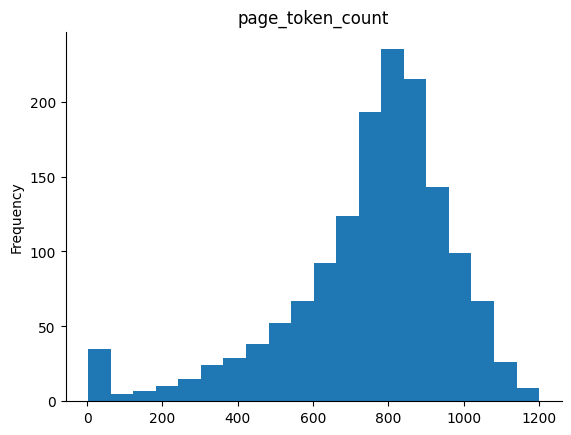

In [47]:
from matplotlib import pyplot as plt
df['page_token_count'].plot(kind='hist', bins=20, title='page_token_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

**Further text processing**

We want to split pages into sentences and chunk them for easier embedding.

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`.

> **Resource:** [spaCy install instructions](https://spacy.io/usage).

In [48]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1485 [00:00<?, ?it/s]

In [49]:
pages_and_texts[:4]

[{'doc_name': 'Law of Torts.pdf',
  'page_number': 1,
  'page_char_count': 2900,
  'page_word_count': 543,
  'page_sentence_count_raw': 16,
  'page_token_count': 725.0,
  'text': 'LAW OF TORTS  Definition of Tort  Definitions of \'Tort\'  Some of the important definitions, which throw light on the nature of tort are follows,  As per Salmond, "A tort is a civil wrong for which the remedy is an action for damages  "and which is not exclusively the breach of contract or the breach of trust or breach of merely  equitable obligation".  As per Winfield, Tortious liability arises from the breach of a duty primarily fixed the law,  this duty is towards the persons generally and its breach is redressible by an action for  unliquidated damages." As per Clark and Lindsell, "Tort is a wrong independent of contract for which the  appropriate remedy is a common law action." As per Fraser, "A tort is an infringement of right in rent of a private individual giving a  right of compensation at the suit 

Let's review the new statistics.

In [50]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1485.00,1485.00,1485.00,1485.00,1485.00,1485.00
mean,367.70,3006.93,524.26,15.77,751.73,15.92
std,272.51,889.71,151.69,8.30,222.43,8.04
min,1.00,11.00,5.00,1.00,2.75,1.00
25%,134.00,2640.00,466.00,10.00,660.00,10.00
50%,320.00,3175.00,551.00,15.00,793.75,16.00
75%,576.00,3565.00,620.00,21.00,891.25,22.00
max,947.00,4802.00,864.00,51.00,1200.50,57.00


For our set of text, it looks like our raw sentence count (e.g. splitting on `". "`) is quite close to what spaCy came up with.

Why do we do this?

1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
3. Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.

On average each of our pages has ~16 sentences and an average total of ~751 tokens per page.

So if we take groups of 8 sentences, then it will be ~375 tokens long.

This gives us plenty of room for the text to embedded by our `all-mpnet-base-v2` model (it has a capacity of 384 tokens).

In [51]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 8

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1485 [00:00<?, ?it/s]

In [52]:
pages_and_texts[:1]

[{'doc_name': 'Law of Torts.pdf',
  'page_number': 1,
  'page_char_count': 2900,
  'page_word_count': 543,
  'page_sentence_count_raw': 16,
  'page_token_count': 725.0,
  'text': 'LAW OF TORTS  Definition of Tort  Definitions of \'Tort\'  Some of the important definitions, which throw light on the nature of tort are follows,  As per Salmond, "A tort is a civil wrong for which the remedy is an action for damages  "and which is not exclusively the breach of contract or the breach of trust or breach of merely  equitable obligation".  As per Winfield, Tortious liability arises from the breach of a duty primarily fixed the law,  this duty is towards the persons generally and its breach is redressible by an action for  unliquidated damages." As per Clark and Lindsell, "Tort is a wrong independent of contract for which the  appropriate remedy is a common law action." As per Fraser, "A tort is an infringement of right in rent of a private individual giving a  right of compensation at the suit 

In [53]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1485.00,1485.00,1485.00,1485.00,1485.00,1485.00,1485.00
mean,367.70,3006.93,524.26,15.77,751.73,15.92,2.44
std,272.51,889.71,151.69,8.30,222.43,8.04,1.02
min,1.00,11.00,5.00,1.00,2.75,1.00,1.00
25%,134.00,2640.00,466.00,10.00,660.00,10.00,2.00
50%,320.00,3175.00,551.00,15.00,793.75,16.00,2.00
75%,576.00,3565.00,620.00,21.00,891.25,22.00,3.00
max,947.00,4802.00,864.00,51.00,1200.50,57.00,8.00


**Creating a new dictionary of individul chunk items**

We aim to embed each chunk of sentences into its unique numerical representation.

To maintain clarity, we will create a list of dictionaries. Each dictionary will contain a single chunk of sentences along with relevant details such as the document name, page number and various statistics about the chunk.

In [54]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["doc_name"] = item["doc_name"]
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# Total no. of chunks
len(pages_and_chunks)

  0%|          | 0/1485 [00:00<?, ?it/s]

3621

In [55]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'doc_name': 'Indian Legal System.pdf',
  'page_number': 41,
  'sentence_chunk': "INDIAN LEGAL SYSTEM PREPARED BY RADHIKA SETH, PLEASE VOTE , BALLOT No.-2 Page 42 of 53 person unless he fell within the ordinary original civil jurisdiction of those courts Howrah being outside the presidency limits of Calcutta was outside such jurisdiction of High Court and writ could not be issued simply because the appellant was a Company's servant. In the opinion of their Lordships, with the transfer of the governmental functions of the Crown the earlier distinction between the subjects of the Crown and the natives was blurred. The distinction could now be interpreted as between the British nationals and the Indian nationals although ail were now British subjects. The power of the High Court to issue writs would still extend to the mofussil in the case of the British nationals, but in case of the Indians, this power was limited to the local limits of the presidency towns. It may be noted that earlier

In [56]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,3621.00,3621.00,3621.00,3621.00
mean,350.44,1219.18,201.74,304.79
std,276.66,707.07,118.31,176.77
min,1.00,3.00,1.00,0.75
25%,113.00,743.00,121.00,185.75
50%,285.00,1147.00,189.00,286.75
75%,548.00,1576.00,262.00,394.00
max,947.00,4246.00,732.00,1061.50


It seems that some of our chunks have a relatively low token count.

Let's review the samples with fewer than 70 tokens (approximately the length of a sentence) to determine if they are worth retaining.

In [57]:
# Show random chunks with under 70 tokens in length
min_token_length = 70
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 29.0 | Text: The Committee is charged with the principal oversight of financial reporting and disclosures and aims to enhance the
Chunk token count: 27.5 | Text: On the death of a sole owner of shares, the rights and liabilities goes in favour of the legal heirs. They are
Chunk token count: 43.25 | Text: MGT.3 with the Registrar of such change or discontinuance. A foreign register shall be deemed to be part of the company’s register (hereafter in this rule referred to as the
Chunk token count: 47.5 | Text: Europe views patenting of “man-made” life in much the same manner as the U. S. patent office. TRIPS Agreement obliges member states to patent micro-organisms. Article 27.3 permits WTO member
Chunk token count: 44.0 | Text: If a Director intends to participate through Electronic Mode, he shall give sufficient prior intimation to the Chairman or the Company Secretary to enable them to make suitable


These don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 70 tokens in length.

In [58]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'doc_name': 'Law of Torts.pdf',
  'page_number': 1,
  'sentence_chunk': 'LAW OF TORTS Definition of Tort Definitions of \'Tort\' Some of the important definitions, which throw light on the nature of tort are follows, As per Salmond, "A tort is a civil wrong for which the remedy is an action for damages "and which is not exclusively the breach of contract or the breach of trust or breach of merely equitable obligation". As per Winfield, Tortious liability arises from the breach of a duty primarily fixed the law, this duty is towards the persons generally and its breach is redressible by an action for unliquidated damages."As per Clark and Lindsell, "Tort is a wrong independent of contract for which the appropriate remedy is a common law action."As per Fraser, "A tort is an infringement of right in rent of a private individual giving a right of compensation at the suit of injured party."As per Section 2(m), the Limitation Act, 1963 "Tort means a civil wrong which is not exclusively a b

### 2. Embedding Creation

Embeddings are numerical representations of data that capture the underlying relationships and patterns within the data. They convert complex, high-dimensional data into lower-dimensional vectors that can be easily processed by machine learning models.

Steps:
1. Use an embedding model to embed the text chunks.
2. Save the embeddings to a file for future reference, ensuring they are preserved.

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order). To do so, we'll use the sentence-transformers library which contains many pre-trained embedding models. Specifically, we'll get the `all-mpnet-base-v2` model.

> **Resource:** [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses).

In [59]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cuda")

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])


  0%|          | 0/3323 [00:00<?, ?it/s]

In [60]:
pages_and_chunks_over_min_token_len[:1]

[{'doc_name': 'Law of Torts.pdf',
  'page_number': 1,
  'sentence_chunk': 'LAW OF TORTS Definition of Tort Definitions of \'Tort\' Some of the important definitions, which throw light on the nature of tort are follows, As per Salmond, "A tort is a civil wrong for which the remedy is an action for damages "and which is not exclusively the breach of contract or the breach of trust or breach of merely equitable obligation". As per Winfield, Tortious liability arises from the breach of a duty primarily fixed the law, this duty is towards the persons generally and its breach is redressible by an action for unliquidated damages."As per Clark and Lindsell, "Tort is a wrong independent of contract for which the appropriate remedy is a common law action."As per Fraser, "A tort is an infringement of right in rent of a private individual giving a right of compensation at the suit of injured party."As per Section 2(m), the Limitation Act, 1963 "Tort means a civil wrong which is not exclusively a b

To improve the speed of embedding creation we can perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.

In [61]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

tensor([[-0.0065, -0.0895,  0.0533,  ...,  0.0484, -0.0408,  0.0319],
        [-0.0062, -0.0840,  0.0364,  ...,  0.0472, -0.0076,  0.0094],
        [-0.0191, -0.1324,  0.0214,  ...,  0.0017, -0.0271,  0.0210],
        ...,
        [ 0.0532, -0.0479, -0.0101,  ...,  0.0604, -0.0824, -0.0200],
        [-0.0011, -0.0608,  0.0060,  ...,  0.0361, -0.0699, -0.0092],
        [ 0.0290, -0.0261, -0.0015,  ...,  0.0074,  0.0087, -0.0358]],
       device='cuda:0')

**Saving embeddings to a file**

1.   List item
2.   List item



In [62]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "/content/drive/MyDrive/Colab Notebooks/text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [63]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,doc_name,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,Law of Torts.pdf,1,LAW OF TORTS Definition of Tort Definitions of...,1347,226,336.75,[-6.48861658e-03 -8.94658864e-02 5.33477291e-...
1,Law of Torts.pdf,1,and to exclude duties arising between guardian...,1104,202,276.00,[-6.24376815e-03 -8.40085596e-02 3.63823734e-...
2,Law of Torts.pdf,1,The detailed discussion is as follows (1) Tort...,407,75,101.75,[-1.91329587e-02 -1.32374823e-01 2.14300137e-...
3,Law of Torts.pdf,2,"LAW OF TORTS Page 3 of 53 criminal wrong, the...",1266,235,316.50,[-2.59581637e-02 -7.33993873e-02 4.63636629e-...
4,Law of Torts.pdf,2,"After the commission of the wrong, it is not p...",1095,184,273.75,[-2.47270297e-02 -1.83070917e-02 4.42395955e-...


### 3. RAG - Search and Answer

Let's import our embeddings we created earlier (tk -link to embedding file) and prepare them for use by turning them into a tensor.

In [64]:
import random

import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([3323, 768])

In [65]:
text_chunks_and_embedding_df.head()

,doc_name,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,Law of Torts.pdf,1,LAW OF TORTS Definition of Tort Definitions of...,1347,226,336.75,"[-0.00648861658, -0.0894658864, 0.0533477291, ..."
1,Law of Torts.pdf,1,and to exclude duties arising between guardian...,1104,202,276.00,"[-0.00624376815, -0.0840085596, 0.0363823734, ..."
2,Law of Torts.pdf,1,The detailed discussion is as follows (1) Tort...,407,75,101.75,"[-0.0191329587, -0.132374823, 0.0214300137, 0...."
3,Law of Torts.pdf,2,"LAW OF TORTS Page 3 of 53 criminal wrong, the...",1266,235,316.50,"[-0.0259581637, -0.0733993873, 0.0463636629, -..."
4,Law of Torts.pdf,2,"After the commission of the wrong, it is not p...",1095,184,273.75,"[-0.0247270297, -0.0183070917, 0.0442395955, -..."


In [66]:
embeddings[0]

tensor([-6.4886e-03, -8.9466e-02,  5.3348e-02, -3.5436e-02, -5.6188e-02,
         6.8341e-03,  2.1265e-03,  3.5206e-02,  4.7266e-02, -2.5662e-02,
         5.0590e-03, -1.1685e-02, -2.2693e-02, -7.3989e-02,  2.6678e-02,
        -1.4329e-02,  3.2497e-03,  4.3085e-02, -1.0595e-02,  2.2245e-02,
        -1.3636e-04,  1.1368e-02,  6.8664e-03, -1.2967e-02, -2.4180e-02,
         5.1835e-04,  7.3566e-02, -4.0124e-02,  1.1063e-02, -4.8868e-02,
         4.1898e-02, -2.0435e-02,  3.6474e-02, -1.2661e-03,  2.4903e-06,
        -3.9791e-02,  1.2183e-02, -3.1528e-02,  6.9694e-04, -2.4298e-03,
        -6.7369e-02, -1.6812e-02,  7.4597e-02,  2.1836e-02,  1.4777e-02,
         8.5114e-02, -4.1239e-03,  7.3553e-03,  1.6681e-03,  7.8724e-02,
        -7.0383e-03, -4.8013e-02, -3.4260e-03, -1.2606e-02,  9.9803e-02,
        -1.3416e-02,  1.1595e-02,  5.0938e-02,  2.8693e-02, -4.5357e-02,
         4.7612e-02, -4.2604e-02,  1.6972e-02,  2.4268e-02, -1.0320e-02,
        -3.3856e-02, -4.1661e-02,  4.3434e-02,  4.6

**Similarity/Semantic Search**

Semantic search is an advanced search technique that aims to improve search accuracy by understanding the context and meaning behind the search query. Instead of relying solely on keyword matching, semantic search algorithms consider the intent, context, and relationships between words to deliver more relevant and accurate search results.

We want to perform semantic search between our available data (documents) and any query.

Well, we can do so with the following steps:
1. Define a query string (e.g. `"IT Act characteristics"`) - note: this could be anything, specific or not.
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding to get similarity scores.
4. Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts.

In [67]:
from sentence_transformers import util

# 1. Define the query
query = "Intellectual Property rights"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: Intellectual Property rights
Time take to get scores on 3323 embeddings: 0.00033 seconds.


torch.return_types.topk(
values=tensor([0.7591, 0.7530, 0.7504, 0.7404, 0.7300], device='cuda:0'),
indices=tensor([ 285,  282,  373, 1310,  328], device='cuda:0'))

In [68]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [69]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"PDF name: {pages_and_chunks[idx]['doc_name']}")
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Intellectual Property rights'

Results:
Score: 0.7591
Text:
Lesson 1 n Introduction 3 have been brought under the umbrella of Intellectual
Property. Intellectual Property Rights are like any other property rights. They
allow the creators (or owners) of Patents, Trademarks or Copyrighted works (as
the case may be) to benefit from their own respective work or investment in a
creation. These rights are outlined in Article 27 of the Universal Declaration
of Human Rights, which provides for the right to benefit from the protection of
moral and material interests resulting from authorship of scientific, literary
or artistic productions. The importance of Intellectual Property was first
recognized in the Paris Convention for the Protection of Industrial Property
(1883) and the Berne Convention for the Protection of Literary and Artistic
Works (1886). Both treaties are administered by the World Intellectual Property
Organization (WIPO). In short, Property Rights in ideas are no differe

The third result seems to be the most relevant, let's inspect the page from the pdf.